# plot Scenic - vasculature all

- load Scenic results
- create anndata with Regulon scores
- plot scores
- plot top regulons per cell type
- plot target genes per regulon

In [1]:
import os, yaml, re
import json
import base64
import zlib
import math

import warnings
from numba import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning) 

from pathlib import Path
import numpy as np
import scipy as sc
import pandas as pd

import loompy as lp
import scanpy as sc

import matplotlib.pyplot as plt

from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from adjustText import adjust_text

In [2]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 2

*load different loom files here:*

In [3]:
result_dir = Path("/lustre/scratch126/cellgen/team205/jp30/vasculature/vasculature_22Jul24//outputs/results/AUCell/")

In [4]:
anndata = "/nfs/team205/ac65/vasculature/after_annotation/annotated_objects/vas_object_for_scenic.h5ad"

annotation_col = "ann_vas_scenic"

In [5]:
loom_files = list(result_dir.glob("**/*.loom"))

In [6]:
dict(enumerate(x.stem for x in loom_files))

{0: 'vasculature_22Jul24_smc_lineage_splitcomb_comb2_pyscenic_output',
 1: 'vasculature_22Jul24_Littoral_EC_lineage_splitcomb_comb2_pyscenic_output',
 2: 'vasculature_22Jul24_capillary_ec_lineage_splitcomb_comb2_pyscenic_output',
 3: 'vasculature_22Jul24_arterial_ec_lineage_splitcomb_comb2_pyscenic_output',
 4: 'vasculature_22Jul24_venous_ec_lineage_splitcomb_comb2_pyscenic_output',
 5: 'vasculature_22Jul24_lymphatic_ec_lineage_splitcomb_comb2_pyscenic_output',
 6: 'vasculature_22Jul24_pericytes_lineage_splitcomb_comb2_pyscenic_output'}

### select one of the lineages

In [7]:
f_final_loom = loom_files[2]

## load results of Scenic pipeline

read processed anndata

In [8]:
ad = sc.read_h5ad(anndata)

read regulons from loom

In [8]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [9]:
# create a dictionary of regulons
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

/tmp/ipykernel_2356629/3801288988.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [10]:
lf.close()

### create anndata with regulon scores

scores in `auc_mtx`

In [11]:
ad_scenic = sc.AnnData(auc_mtx)

In [12]:
ad_scenic = ad_scenic[ad_scenic.obs_names.isin(ad.obs_names)]

add cell annotation

In [13]:
ad_scenic.obs_names_make_unique()

In [14]:
ad.obs_names_make_unique()

In [15]:
ad_scenic.obs = ad_scenic.obs.merge(ad.obs, how='left', left_index=True, right_index=True)

add original umap (based on GEX)

In [16]:
ad_scenic.obsm["X_umap_genes"] = ad[ad_scenic.obs_names].obsm["X_umap"]

In [17]:
ad_scenic.obs[annotation_col] = ad_scenic.obs[annotation_col].astype(str).astype('category')

In [18]:
ad_scenic

AnnData object with n_obs × n_vars = 6407 × 689
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'doublet_pval'

original umap

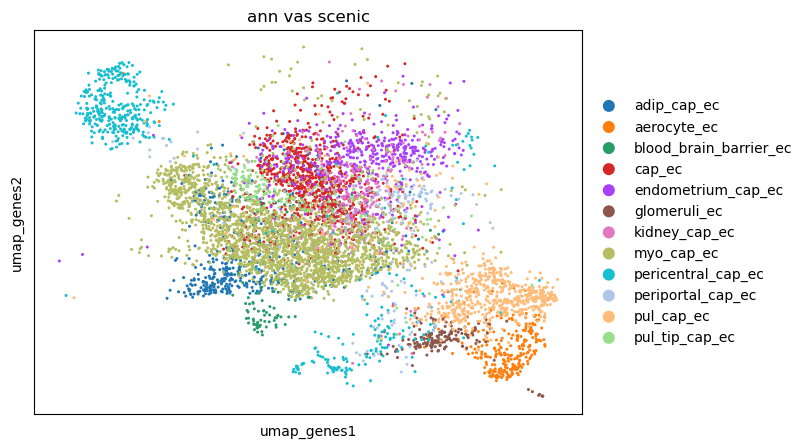

In [19]:
sc.pl.scatter(ad_scenic, color = annotation_col, basis = "umap_genes")

### plot UMAP

create embedding for cells based on regulon scores

In [20]:
sc.pp.highly_variable_genes(ad_scenic)

In [21]:
sc.pp.scale(ad_scenic)

In [22]:
sc.tl.pca(ad_scenic)

In [23]:
sc.pp.neighbors(ad_scenic)

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.tl.paga(ad_scenic, groups=annotation_col)

In [25]:
ad_scenic.obs[annotation_col].value_counts()

myo_cap_ec                2170
cap_ec                     916
pul_cap_ec                 630
adip_cap_ec                511
pericentral_cap_ec         503
endometrium_cap_ec         493
kidney_cap_ec              294
aerocyte_ec                265
periportal_cap_ec          192
glomeruli_ec               172
pul_tip_cap_ec             155
blood_brain_barrier_ec     106
Name: ann_vas_scenic, dtype: int64

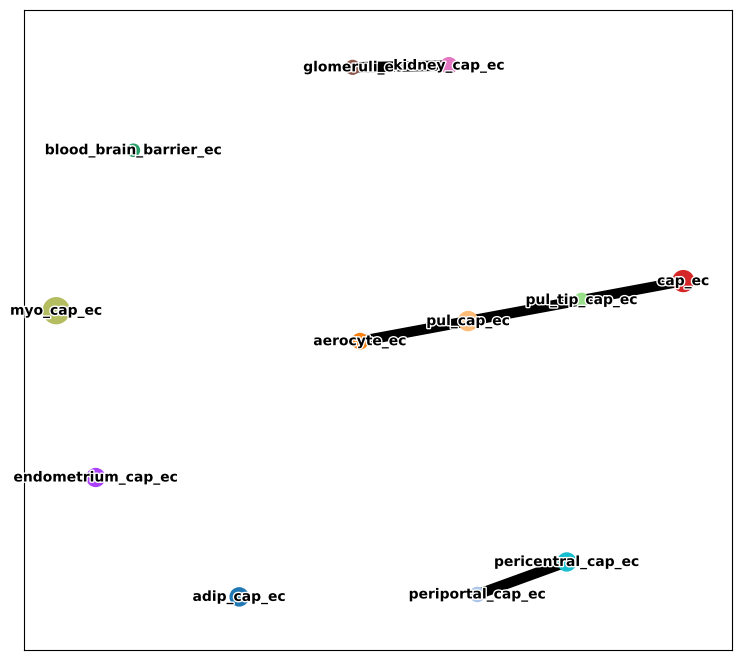

In [26]:
with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": 100, "figure.frameon": True, "figure.facecolor": "white"}):
    sc.pl.paga(ad_scenic, threshold=0.7, fontoutline=2)

In [27]:
sc.tl.umap(ad_scenic, init_pos="paga")

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


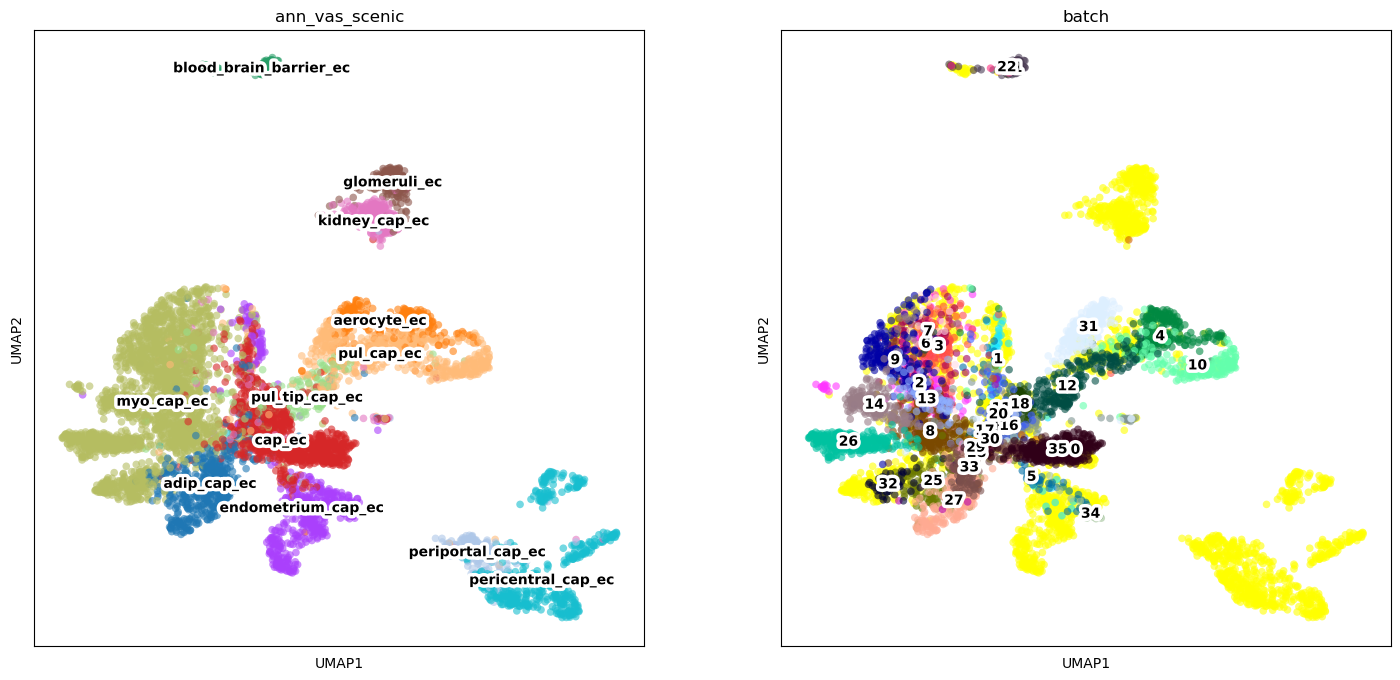

In [28]:
with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": 100, "figure.frameon": True, "figure.facecolor": "white"}):
    sc.pl.umap(
        ad_scenic, 
        color = [
            x
            for x in [annotation_col, "batch"]
            if x in ad_scenic.obs
        ], 
        legend_loc = "on data",
        ncols = 2,
        frameon = True, 
        legend_fontoutline = 5,
        size=120, 
        alpha = 0.6,
#         save="scenic_umap.png"
    )

## regulon specificity scores (RSS)

keep only positive regulators for RSS calculation

In [29]:
ad_scenic = ad_scenic[:,["(+)" in x for x in ad_scenic.var_names]]

In [30]:
auc_mtx = auc_mtx.loc[:,["(+)" in x for x in auc_mtx.columns]]

find regulons that are specific for each cell type

In [31]:
cats = sorted(ad_scenic.obs[annotation_col].unique().tolist())

In [32]:
rss_cellType = regulon_specificity_scores(auc_mtx, ad_scenic.obs[annotation_col])

In [33]:
rss_cellType

,ARID3A(+),ARNT(+),ARNT2(+),ARNTL(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF831(+),ZNF84(+),ZNF846(+),ZNF85(+),ZNF860(+),ZNF91(+),ZSCAN1(+),ZSCAN23(+),ZSCAN31(+),ZSCAN32(+)
blood_brain_barrier_ec,0.194678,0.191528,0.456133,0.180024,0.184914,0.175875,0.195307,0.174587,0.172442,0.202909,...,0.179451,0.171107,0.219276,0.179469,0.194148,0.191790,0.199492,0.177681,0.182946,0.199938
myo_cap_ec,0.332581,0.437707,0.268214,0.404272,0.379812,0.448625,0.448862,0.426493,0.459373,0.423398,...,0.282713,0.307813,0.360334,0.359710,0.351446,0.439826,0.355535,0.362052,0.394198,0.408403
cap_ec,0.281183,0.293720,0.210756,0.277897,0.358590,0.303882,0.296084,0.269836,0.279840,0.294745,...,0.215696,0.261861,0.260597,0.267086,0.286411,0.301127,0.290230,0.227059,0.291534,0.301917
adip_cap_ec,0.225421,0.259402,0.205739,0.258804,0.245813,0.236085,0.265005,0.248536,0.279247,0.241218,...,0.203910,0.262632,0.239580,0.236867,0.256798,0.268547,0.253584,0.218115,0.252401,0.268028
pul_cap_ec,0.338536,0.271690,0.214185,0.237597,0.267859,0.271228,0.275562,0.298001,0.271195,0.279173,...,0.205532,0.264739,0.255988,0.239488,0.241520,0.273829,0.231558,0.210349,0.236900,0.250578
kidney_cap_ec,0.211217,0.225297,0.197209,0.210800,0.214403,0.219579,0.219579,0.209425,0.211095,0.228887,...,0.238524,0.216290,0.212634,0.209198,0.215915,0.233537,0.220559,0.185688,0.216141,0.230103
endometrium_cap_ec,0.255548,0.234502,0.176118,0.229009,0.264923,0.259764,0.228951,0.233974,0.239179,0.234830,...,0.244267,0.218707,0.285901,0.225849,0.227587,0.233691,0.252751,0.188272,0.278845,0.228149
aerocyte_ec,0.312913,0.219987,0.181267,0.209033,0.203316,0.219366,0.213053,0.217242,0.211813,0.229582,...,0.188257,0.219638,0.212420,0.210435,0.203704,0.225899,0.196674,0.187207,0.199932,0.208076
pericentral_cap_ec,0.232387,0.271590,0.235011,0.245734,0.234810,0.261009,0.256362,0.291050,0.260334,0.259259,...,0.234212,0.248939,0.271783,0.231624,0.312218,0.247993,0.231501,0.182571,0.218989,0.225067
pul_tip_cap_ec,0.197379,0.197401,0.176044,0.196880,0.209008,0.202212,0.202181,0.213609,0.199883,0.197808,...,0.181477,0.190405,0.207880,0.188714,0.190915,0.197343,0.198939,0.228480,0.204388,0.193940


In [37]:
rss_cellType.to_csv('rss_capillary.csv')

# cap

In [38]:
cap = pd.read_csv("./rss_capillary.csv")
cap

,Unnamed: 0,ARID3A(+),ARNT(+),ARNT2(+),ARNTL(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),...,ZNF831(+),ZNF84(+),ZNF846(+),ZNF85(+),ZNF860(+),ZNF91(+),ZSCAN1(+),ZSCAN23(+),ZSCAN31(+),ZSCAN32(+)
0,blood_brain_barrier_ec,0.194678,0.191528,0.456133,0.180024,0.184914,0.175875,0.195307,0.174587,0.172442,...,0.179451,0.171107,0.219276,0.179469,0.194148,0.191790,0.199492,0.177681,0.182946,0.199938
1,myo_cap_ec,0.332581,0.437707,0.268214,0.404272,0.379812,0.448625,0.448862,0.426493,0.459373,...,0.282713,0.307813,0.360334,0.359710,0.351446,0.439826,0.355535,0.362052,0.394198,0.408403
2,cap_ec,0.281183,0.293720,0.210756,0.277897,0.358590,0.303882,0.296084,0.269836,0.279840,...,0.215696,0.261861,0.260597,0.267086,0.286411,0.301127,0.290230,0.227059,0.291534,0.301917
3,adip_cap_ec,0.225421,0.259402,0.205739,0.258804,0.245813,0.236085,0.265005,0.248536,0.279247,...,0.203910,0.262632,0.239580,0.236867,0.256798,0.268547,0.253584,0.218115,0.252401,0.268028
4,pul_cap_ec,0.338536,0.271690,0.214185,0.237597,0.267859,0.271228,0.275562,0.298001,0.271195,...,0.205532,0.264739,0.255988,0.239488,0.241520,0.273829,0.231558,0.210349,0.236900,0.250578
5,kidney_cap_ec,0.211217,0.225297,0.197209,0.210800,0.214403,0.219579,0.219579,0.209425,0.211095,...,0.238524,0.216290,0.212634,0.209198,0.215915,0.233537,0.220559,0.185688,0.216141,0.230103
6,endometrium_cap_ec,0.255548,0.234502,0.176118,0.229009,0.264923,0.259764,0.228951,0.233974,0.239179,...,0.244267,0.218707,0.285901,0.225849,0.227587,0.233691,0.252751,0.188272,0.278845,0.228149
7,aerocyte_ec,0.312913,0.219987,0.181267,0.209033,0.203316,0.219366,0.213053,0.217242,0.211813,...,0.188257,0.219638,0.212420,0.210435,0.203704,0.225899,0.196674,0.187207,0.199932,0.208076
8,pericentral_cap_ec,0.232387,0.271590,0.235011,0.245734,0.234810,0.261009,0.256362,0.291050,0.260334,...,0.234212,0.248939,0.271783,0.231624,0.312218,0.247993,0.231501,0.182571,0.218989,0.225067
9,pul_tip_cap_ec,0.197379,0.197401,0.176044,0.196880,0.209008,0.202212,0.202181,0.213609,0.199883,...,0.181477,0.190405,0.207880,0.188714,0.190915,0.197343,0.198939,0.228480,0.204388,0.193940


In [ ]:
cap.set_index('Unnamed: 0', inplace=True)

In [41]:
cap

,ARID3A(+),ARNT(+),ARNT2(+),ARNTL(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF831(+),ZNF84(+),ZNF846(+),ZNF85(+),ZNF860(+),ZNF91(+),ZSCAN1(+),ZSCAN23(+),ZSCAN31(+),ZSCAN32(+)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
blood_brain_barrier_ec,0.194678,0.191528,0.456133,0.180024,0.184914,0.175875,0.195307,0.174587,0.172442,0.202909,...,0.179451,0.171107,0.219276,0.179469,0.194148,0.191790,0.199492,0.177681,0.182946,0.199938
myo_cap_ec,0.332581,0.437707,0.268214,0.404272,0.379812,0.448625,0.448862,0.426493,0.459373,0.423398,...,0.282713,0.307813,0.360334,0.359710,0.351446,0.439826,0.355535,0.362052,0.394198,0.408403
cap_ec,0.281183,0.293720,0.210756,0.277897,0.358590,0.303882,0.296084,0.269836,0.279840,0.294745,...,0.215696,0.261861,0.260597,0.267086,0.286411,0.301127,0.290230,0.227059,0.291534,0.301917
adip_cap_ec,0.225421,0.259402,0.205739,0.258804,0.245813,0.236085,0.265005,0.248536,0.279247,0.241218,...,0.203910,0.262632,0.239580,0.236867,0.256798,0.268547,0.253584,0.218115,0.252401,0.268028
pul_cap_ec,0.338536,0.271690,0.214185,0.237597,0.267859,0.271228,0.275562,0.298001,0.271195,0.279173,...,0.205532,0.264739,0.255988,0.239488,0.241520,0.273829,0.231558,0.210349,0.236900,0.250578
kidney_cap_ec,0.211217,0.225297,0.197209,0.210800,0.214403,0.219579,0.219579,0.209425,0.211095,0.228887,...,0.238524,0.216290,0.212634,0.209198,0.215915,0.233537,0.220559,0.185688,0.216141,0.230103
endometrium_cap_ec,0.255548,0.234502,0.176118,0.229009,0.264923,0.259764,0.228951,0.233974,0.239179,0.234830,...,0.244267,0.218707,0.285901,0.225849,0.227587,0.233691,0.252751,0.188272,0.278845,0.228149
aerocyte_ec,0.312913,0.219987,0.181267,0.209033,0.203316,0.219366,0.213053,0.217242,0.211813,0.229582,...,0.188257,0.219638,0.212420,0.210435,0.203704,0.225899,0.196674,0.187207,0.199932,0.208076
pericentral_cap_ec,0.232387,0.271590,0.235011,0.245734,0.234810,0.261009,0.256362,0.291050,0.260334,0.259259,...,0.234212,0.248939,0.271783,0.231624,0.312218,0.247993,0.231501,0.182571,0.218989,0.225067


In [42]:
cap = cap.loc[['aerocyte_ec','pul_cap_ec','pul_tip_cap_ec','pericentral_cap_ec','periportal_cap_ec',
               'glomeruli_ec', 'kidney_cap_ec','endometrium_cap_ec','myo_cap_ec','adip_cap_ec', 'blood_brain_barrier_ec'
              ]]
cap

,ARID3A(+),ARNT(+),ARNT2(+),ARNTL(+),ARNTL2(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF831(+),ZNF84(+),ZNF846(+),ZNF85(+),ZNF860(+),ZNF91(+),ZSCAN1(+),ZSCAN23(+),ZSCAN31(+),ZSCAN32(+)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
aerocyte_ec,0.312913,0.219987,0.181267,0.209033,0.203316,0.219366,0.213053,0.217242,0.211813,0.229582,...,0.188257,0.219638,0.212420,0.210435,0.203704,0.225899,0.196674,0.187207,0.199932,0.208076
pul_cap_ec,0.338536,0.271690,0.214185,0.237597,0.267859,0.271228,0.275562,0.298001,0.271195,0.279173,...,0.205532,0.264739,0.255988,0.239488,0.241520,0.273829,0.231558,0.210349,0.236900,0.250578
pul_tip_cap_ec,0.197379,0.197401,0.176044,0.196880,0.209008,0.202212,0.202181,0.213609,0.199883,0.197808,...,0.181477,0.190405,0.207880,0.188714,0.190915,0.197343,0.198939,0.228480,0.204388,0.193940
pericentral_cap_ec,0.232387,0.271590,0.235011,0.245734,0.234810,0.261009,0.256362,0.291050,0.260334,0.259259,...,0.234212,0.248939,0.271783,0.231624,0.312218,0.247993,0.231501,0.182571,0.218989,0.225067
periportal_cap_ec,0.201412,0.210467,0.191048,0.205624,0.209889,0.216400,0.214298,0.223380,0.216178,0.214458,...,0.211405,0.208649,0.216172,0.197212,0.231394,0.206668,0.212809,0.176990,0.196216,0.195016
glomeruli_ec,0.199915,0.200223,0.204219,0.195701,0.189678,0.196598,0.199099,0.197175,0.194763,0.213801,...,0.236053,0.191121,0.198025,0.196013,0.193504,0.213110,0.194723,0.193956,0.194774,0.217249
kidney_cap_ec,0.211217,0.225297,0.197209,0.210800,0.214403,0.219579,0.219579,0.209425,0.211095,0.228887,...,0.238524,0.216290,0.212634,0.209198,0.215915,0.233537,0.220559,0.185688,0.216141,0.230103
endometrium_cap_ec,0.255548,0.234502,0.176118,0.229009,0.264923,0.259764,0.228951,0.233974,0.239179,0.234830,...,0.244267,0.218707,0.285901,0.225849,0.227587,0.233691,0.252751,0.188272,0.278845,0.228149
myo_cap_ec,0.332581,0.437707,0.268214,0.404272,0.379812,0.448625,0.448862,0.426493,0.459373,0.423398,...,0.282713,0.307813,0.360334,0.359710,0.351446,0.439826,0.355535,0.362052,0.394198,0.408403


In [45]:
lf = lp.connect('/lustre/scratch126/cellgen/team205/jp30/vasculature/vasculature_22Jul24/outputs/results/AUCell/vasculature_22Jul24_capillary_ec_lineage_splitcomb_comb2/vasculature_22Jul24_capillary_ec_lineage_splitcomb_comb2_pyscenic_output.loom', mode='r', validate=False)
regulons_cap = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons_cap[i] =  list(r[r==1].index.values)

/tmp/ipykernel_2356629/2650879513.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():


In [46]:
annotation_col = "ann_vas_scenic"

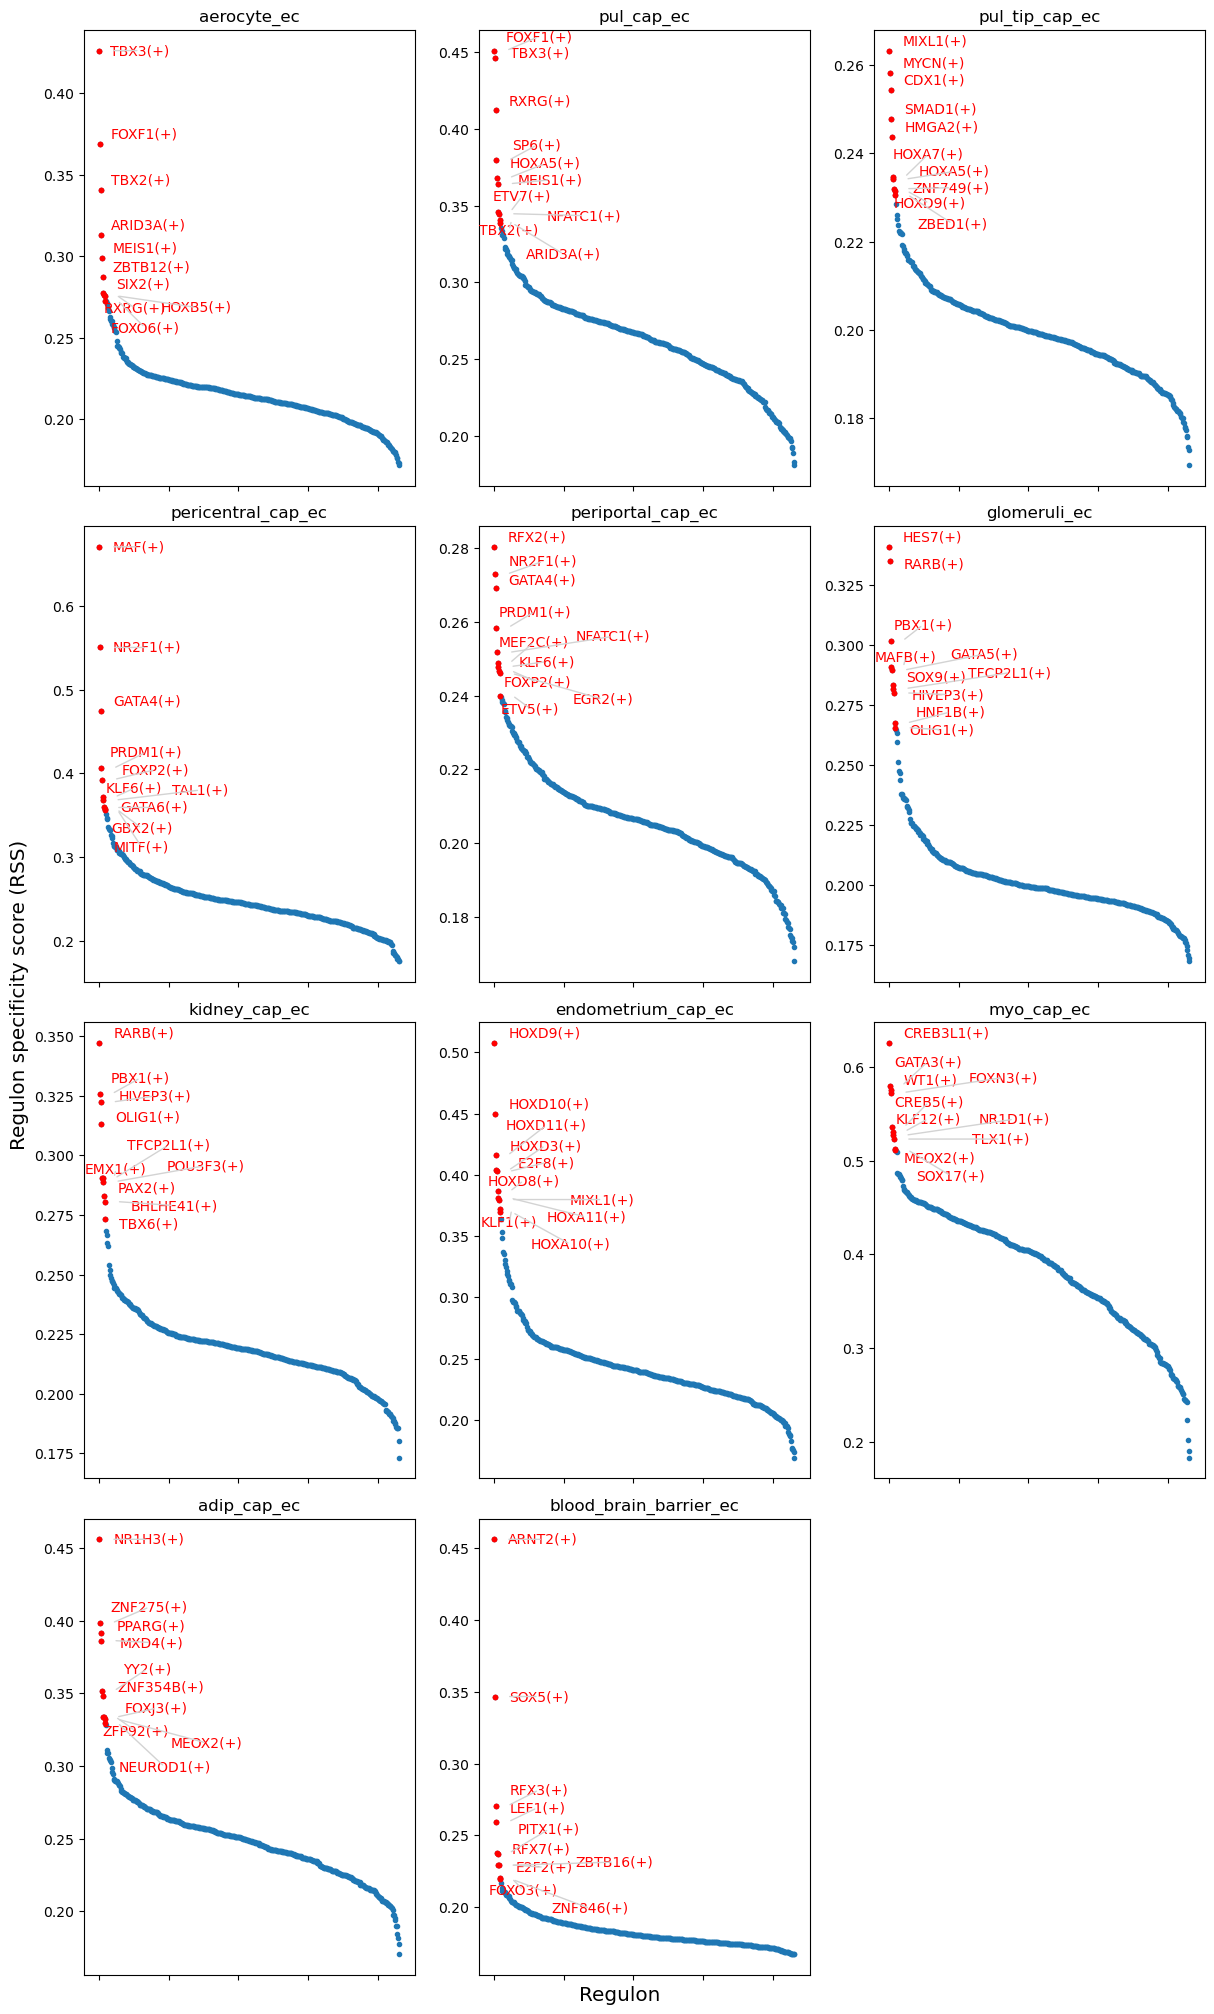

In [47]:
cats = cap.index.tolist()
rss_cellType = cap

N = len(cats)
ncols = 3
nrows = math.ceil(N / ncols)

fig = plt.figure(figsize=(4*ncols, 5*nrows))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(nrows, ncols, num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large',
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
# plt.savefig("../../SCENIC/tip_stalk_secretory_23Sep21_3/rss_top5.png", dpi=600, bbox_inches = "tight")
plt.show()

In [48]:
def top_columns_for_each_row(df, n=10):
    top_columns_list = []
    for index, row in df.iterrows():
        top_columns = row.nlargest(n).index.tolist()
        top_columns_list.append(top_columns)
    top_columns_df = pd.DataFrame(top_columns_list, columns=[f'Top_{i+1}' for i in range(n)])
    return top_columns_df

In [49]:
# Call the function with your DataFrame and specify the number of top columns (n)
cap_top5_TF = top_columns_for_each_row(cap, 5)
cap_top5_TF.index = cap.index
cap_top5_TF

,Top_1,Top_2,Top_3,Top_4,Top_5
Unnamed: 0,,,,,
aerocyte_ec,TBX3(+),FOXF1(+),TBX2(+),ARID3A(+),MEIS1(+)
pul_cap_ec,FOXF1(+),TBX3(+),RXRG(+),SP6(+),HOXA5(+)
pul_tip_cap_ec,MIXL1(+),MYCN(+),CDX1(+),SMAD1(+),HMGA2(+)
pericentral_cap_ec,MAF(+),NR2F1(+),GATA4(+),PRDM1(+),FOXP2(+)
periportal_cap_ec,RFX2(+),NR2F1(+),GATA4(+),PRDM1(+),NFATC1(+)
glomeruli_ec,HES7(+),RARB(+),PBX1(+),MAFB(+),GATA5(+)
kidney_cap_ec,RARB(+),PBX1(+),HIVEP3(+),OLIG1(+),EMX1(+)
endometrium_cap_ec,HOXD9(+),HOXD10(+),HOXD11(+),HOXD3(+),E2F8(+)
myo_cap_ec,CREB3L1(+),GATA3(+),WT1(+),FOXN3(+),CREB5(+)


## DE TF

In [50]:
cats = cap.index.tolist()
ad_cap = ad[ad.obs[annotation_col].isin(cats)]
ad_cap

View of AnnData object with n_obs × n_vars = 19794 × 30021
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'do

In [51]:
cap_TF = cap.columns.tolist()
cap_TF_genes = [name.replace("(+)", "") for name in cap_TF]

In [52]:
ad_cap_TF = ad_cap[:, cap_TF_genes]

In [53]:
ad_cap_TF

View of AnnData object with n_obs × n_vars = 19794 × 432
    obs: 'orig.ident', 'Sample', 'Winkler_annotation_ec', 'Winkler_annotation_mural', 'Winkler_annotation_mural_fine', 'donor', 'kit', 'study', 'organ_uni', 'Winkler_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'Winkler_broad_annotation', 'id', 'organ', 'sorting', 'location', 'age', 'gender', 'dissociation', 'scrublet_score', 'doublet_bh_pval', 'published_annotation', 'HCA', 'published_annotation_skin', 'batch', 'cell_ontology_class', 'free_annotation', 'compartment', 'age2', 'barcode', 'concat_sample_no', 'Population ', 'hospital_id', 'Organ', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'doub

In [54]:
del ad_cap_TF.layers['counts']

/tmp/ipykernel_2356629/4282490330.py:1: ImplicitModificationWarning: Removing element `.layers['counts']` of view, initializing view as actual.
  del ad_cap_TF.layers['counts']


In [55]:
sc.tl.rank_genes_groups(ad_cap_TF, groupby="ann_vas_scenic", method='wilcoxon')

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


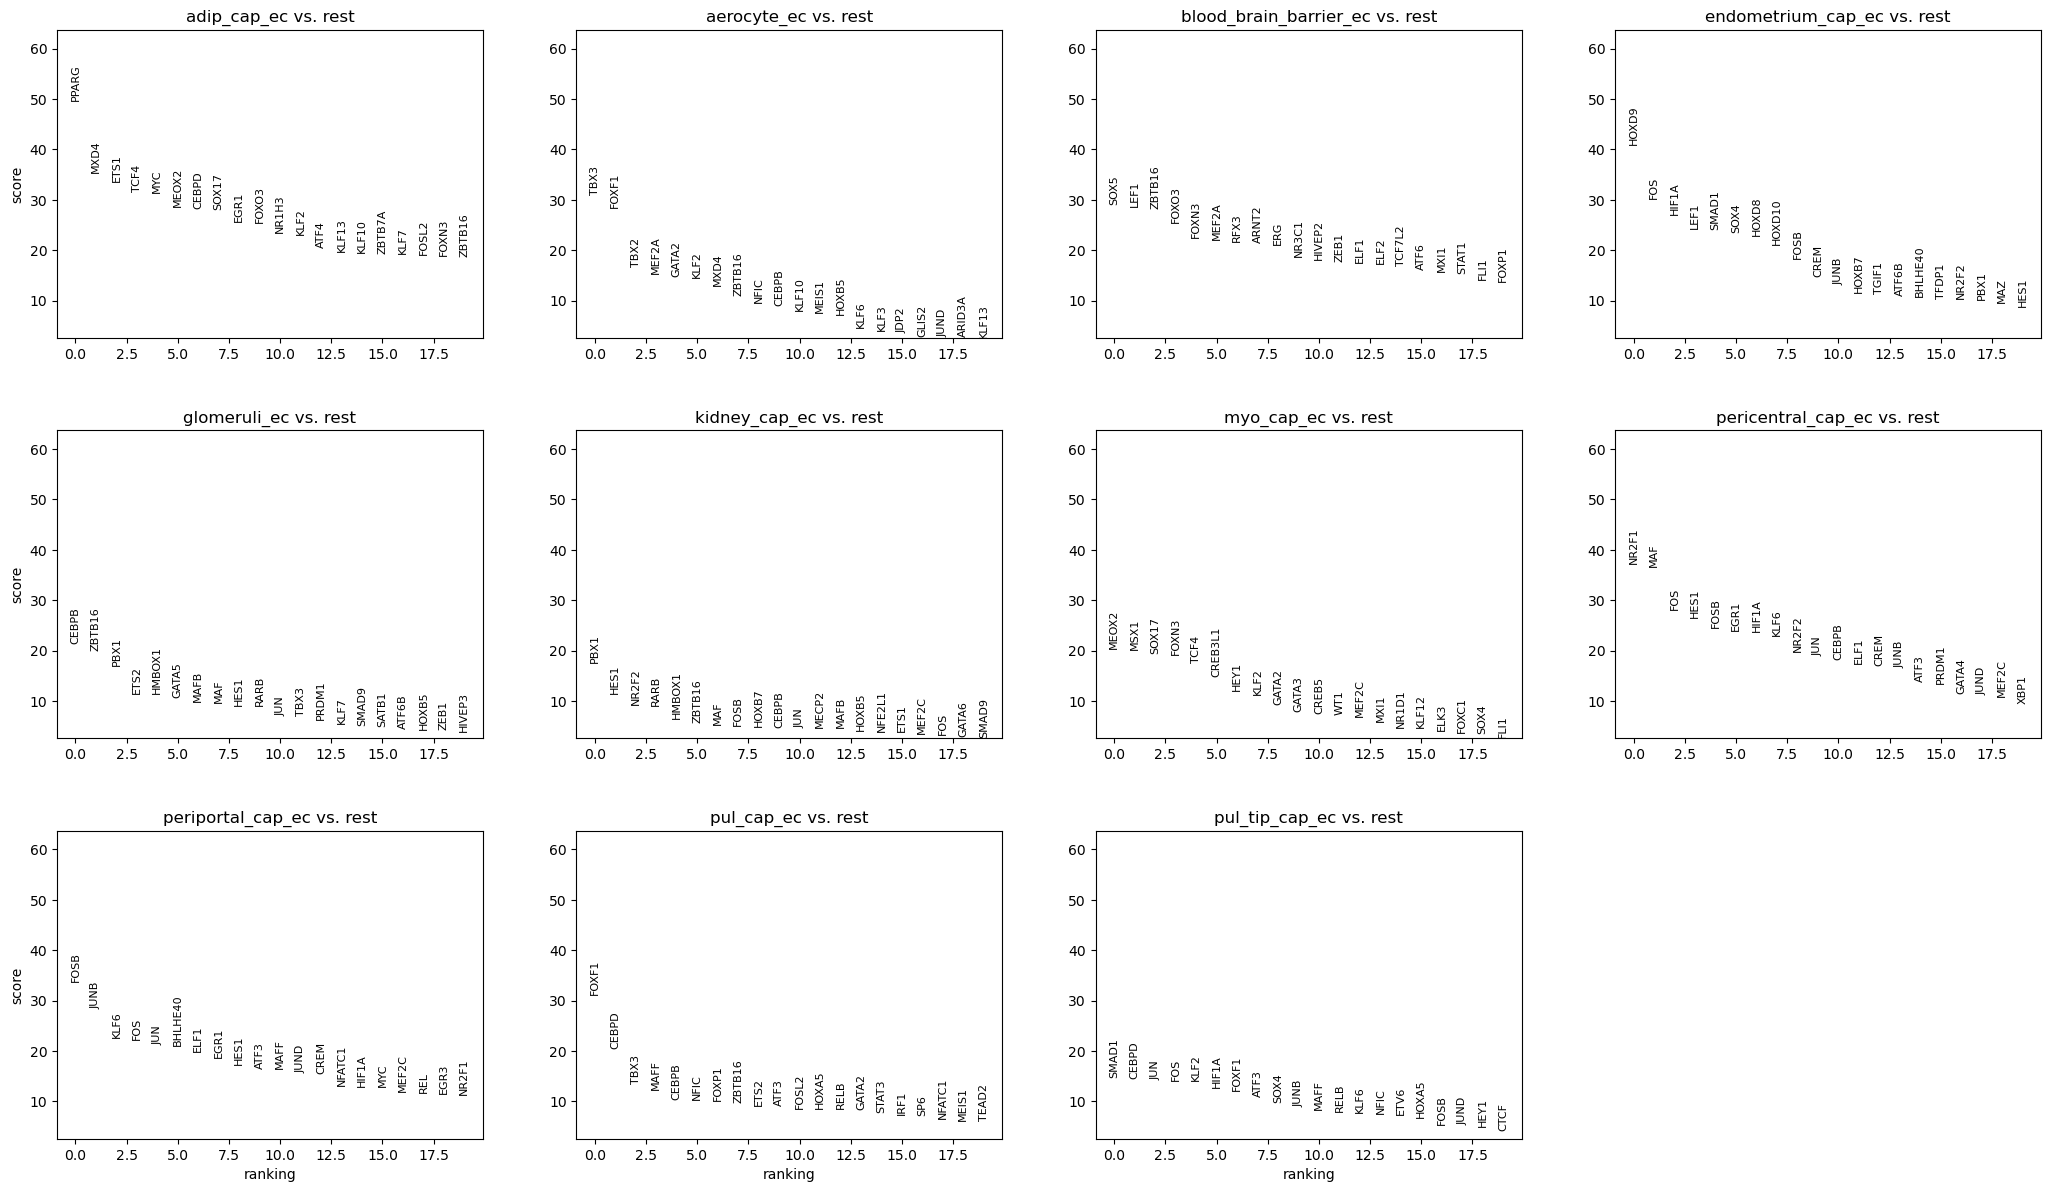

In [56]:
sc.pl.rank_genes_groups(ad_cap_TF)

In [57]:
sc.tl.filter_rank_genes_groups(ad_cap_TF, 
                               groupby='ann_vas_scenic', 
                               key_added="ranked_TFs_filtered",
                               min_in_group_fraction=0.25, 
                               min_fold_change=2,
                               max_out_group_fraction=0.25, 
                               use_raw=False)

In [58]:
result = ad_cap_TF.uns['ranked_TFs_filtered']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names','pvals_adj','logfoldchanges']})
df.to_csv('./ranked_DE_TFs_filtered_cap.csv')

## DE genes

In [59]:
sc.tl.rank_genes_groups(ad_cap, groupby="ann_vas_scenic", method='wilcoxon')

/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/nfs/team205/ac65/miniconda3/envs/scanpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


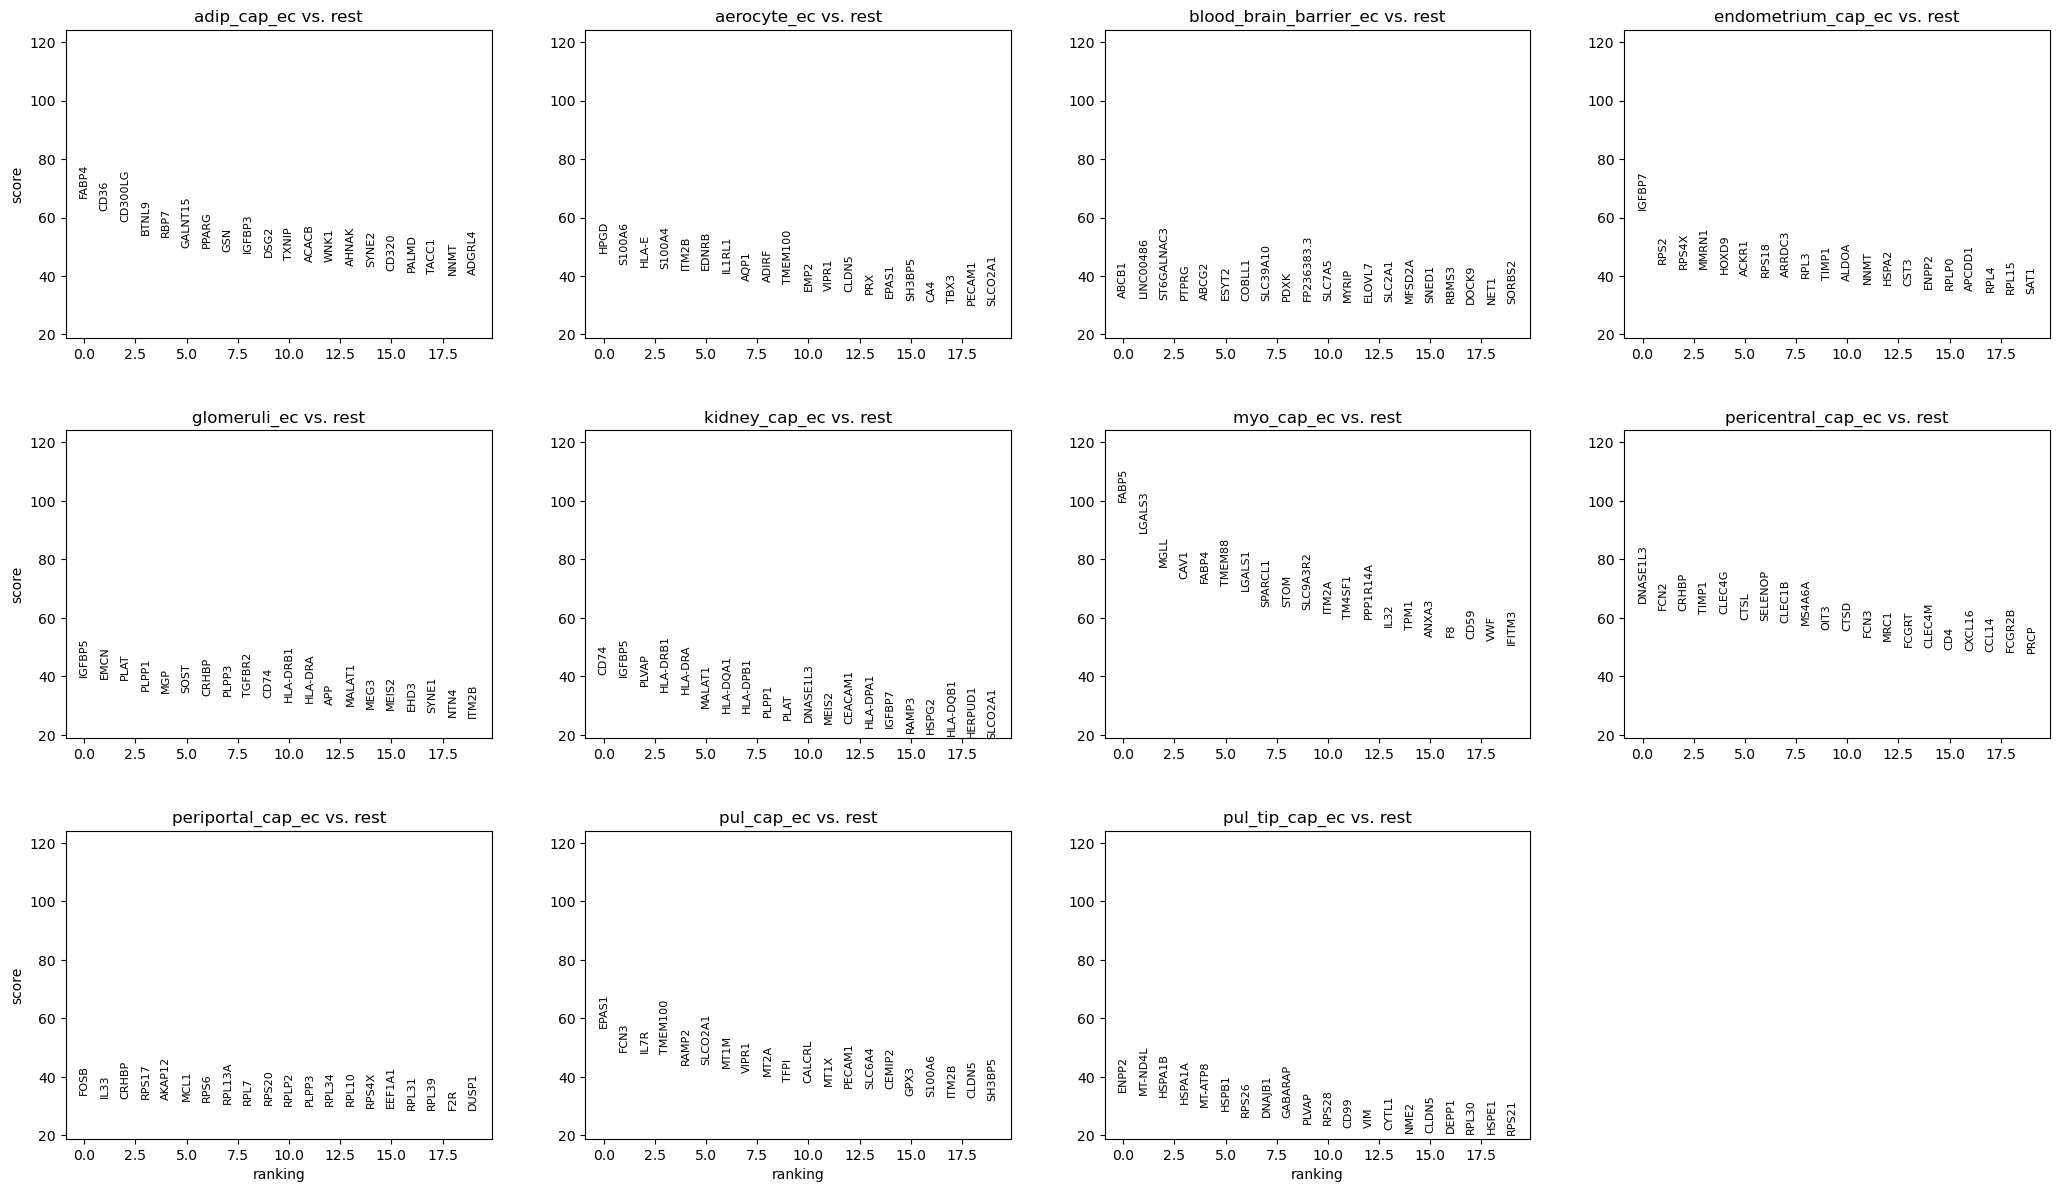

In [60]:
sc.pl.rank_genes_groups(ad_cap)

In [61]:
sc.tl.filter_rank_genes_groups(ad_cap, 
                               groupby='ann_vas_scenic', 
                               key_added="ranked_genes_filtered",
                               min_in_group_fraction=0.25, 
                               min_fold_change=2,
                               max_out_group_fraction=0.25, 
                               use_raw=False)

In [62]:
result = ad_cap.uns['ranked_genes_filtered']
groups = result['names'].dtype.names
df = pd.DataFrame({group + '_' + key[:1]: result[key][group]
                   for group in groups for key in ['names','pvals_adj','logfoldchanges']})
df.to_csv('./ranked_DE_genes_filtered_cap.csv')

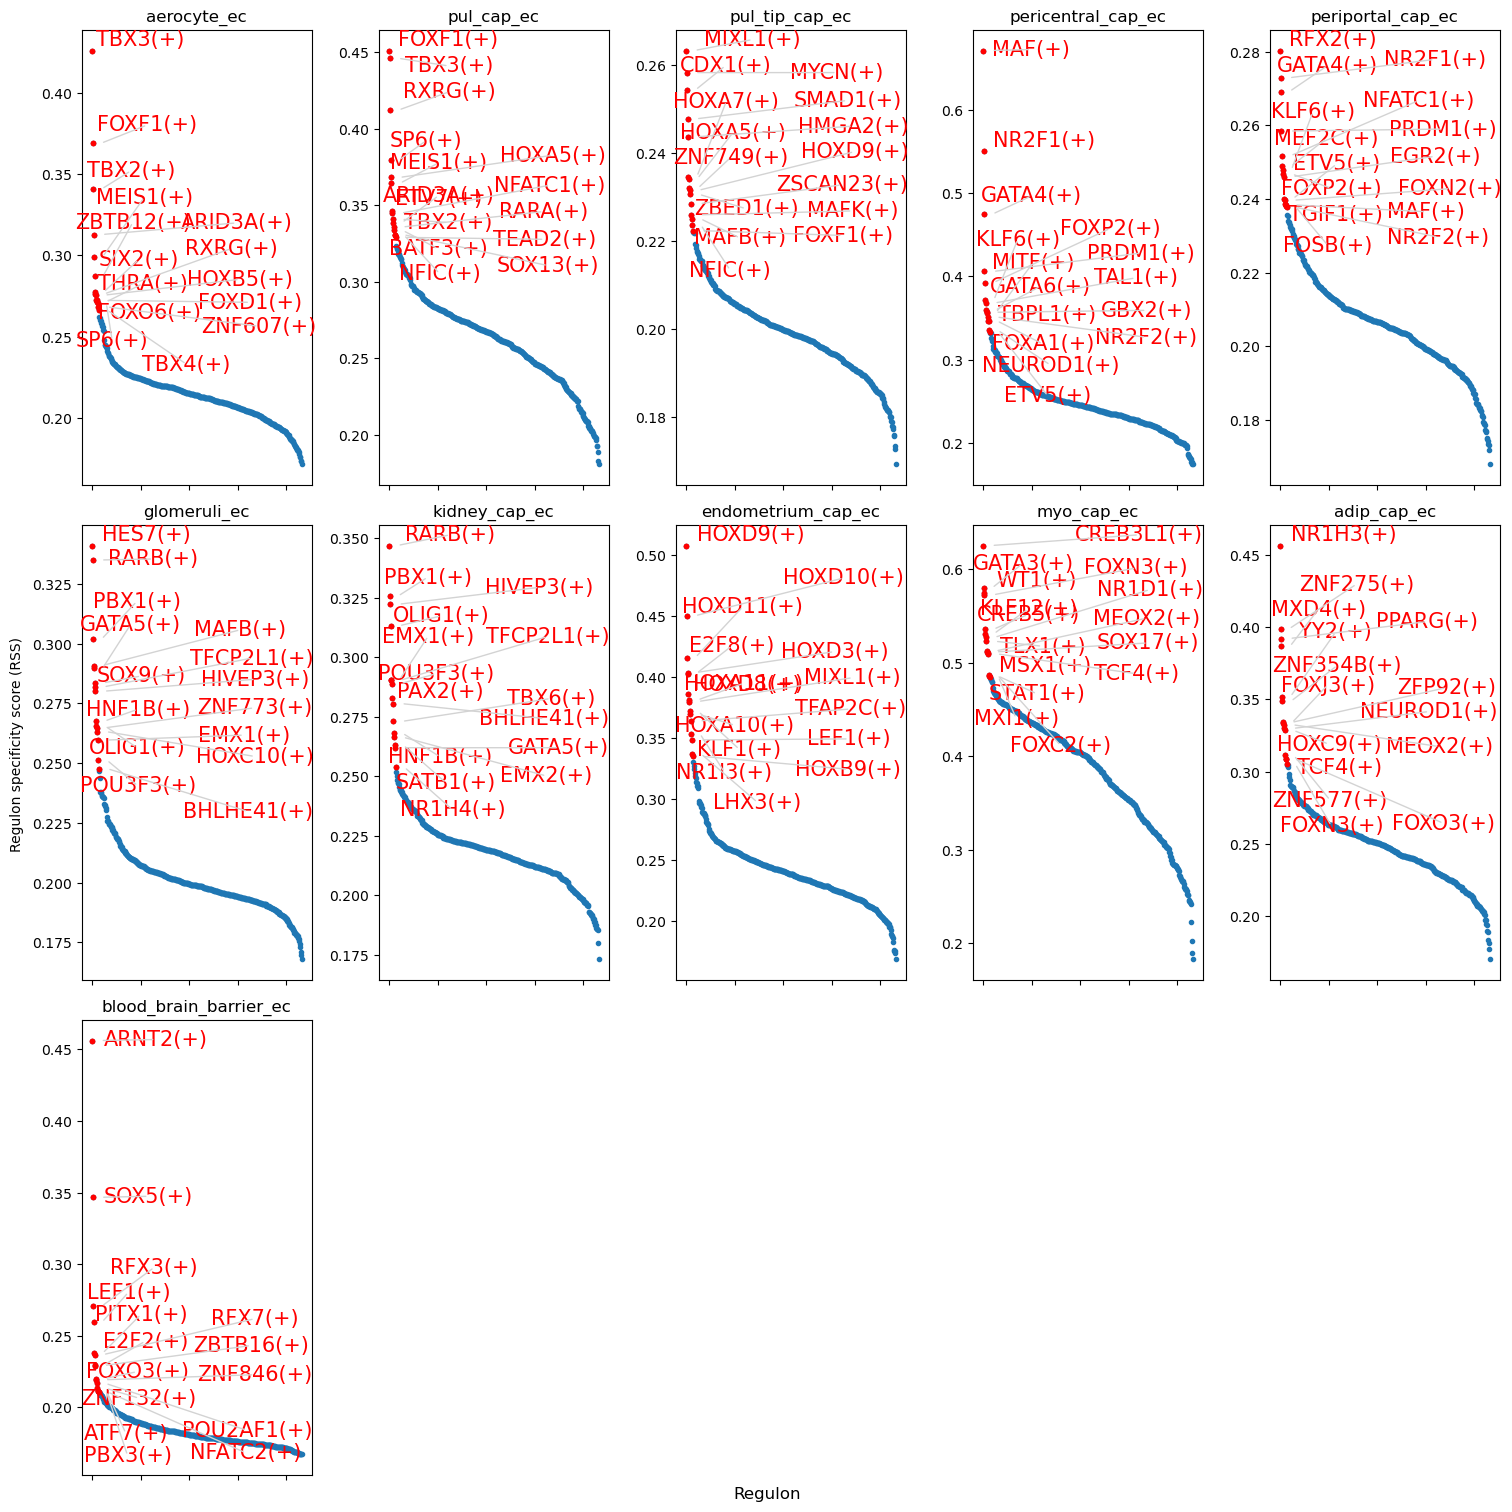

In [64]:
N = len(cats)
ncols = 5
nrows = math.ceil(N / ncols)

fig = plt.figure(figsize=(3*ncols, 5*nrows))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(nrows, ncols, num)
    plot_rss(rss_cellType, c, top_n=15, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(15)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='medium')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large',
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
# plt.savefig("../../SCENIC/tip_stalk_secretory_23Sep21_3/rss_top5.png", dpi=600, bbox_inches = "tight")
plt.show()